In [1]:
%load_ext autoreload
%autoreload 2
import os, re

import discovery as ds
# import PTMCMCSampler


import numpy as np

import jax
import jax.numpy as jnp
import glob
import matplotlib.pyplot as plt
import numpyro
from numpyro import distributions as dist, infer
plt.style.use("/Users/patrickmeyers/Documents/Documents - Patrick’s MacBook Pro/Notes/cross_validation/meyers_latex.mplstyle")
import sys
sys.path.append("../modules")
import models as lncass_models
from lncass import PRIOR_DICT

/Users/patrickmeyers/Documents/Documents - Patrick’s MacBook Pro/repositories/pulsar_timing/flexible_pta_spectral_models/notebooks/../modules/lncass.py:55: RuntimeWarning: invalid value encountered in scalar divide
  beta = (1 - u) / alpha


In [2]:
import pyarrow
import json

class PulsarNoDMX:
    # notes: currently ignores _isort/__isort and gets sorted versions

    columns = ['toas', 'stoas', 'toaerrs', 'residuals', 'freqs', 'backend_flags']
    vector_columns = ['Mmat', 'sunssb', 'pos_t']
    tensor_columns = ['planetssb']
    # flags are done separately

    metadata = ['name', 'dm', 'dm', 'pdist', 'pos', 'phi', 'theta']

    def __init__(self):
        pass

    def __str__(self):
        return f'<PulsarNoDMX {self.name}: {len(self.residuals)} res, {self.Mmat.shape[1]} pars>'

    def __repr__(self):
        return str(self)

    @classmethod
    def read_feather(cls, filename):
        f = pyarrow.feather.read_table(filename)
        self = PulsarNoDMX()

        for array in PulsarNoDMX.columns:
            if array in f.column_names:
                setattr(self, array, f[array].to_numpy())

        for array in PulsarNoDMX.vector_columns:
            cols = [c for c in f.column_names if c.startswith(array)]
            setattr(self, array, np.array([f[col].to_numpy() for col in cols]).swapaxes(0,1).copy())

        for array in PulsarNoDMX.tensor_columns:
            rows = sorted(set(['_'.join(c.split('_')[:-1]) for c in f.column_names if c.startswith(array)]))
            cols = [[c for c in f.column_names if c.startswith(row)] for row in rows]
            setattr(self, array,
                    np.array([[f[col].to_numpy() for col in row] for row in cols]).swapaxes(0,2).swapaxes(1,2).copy())

        self.flags = {}
        for array in [c for c in f.column_names if c.startswith('flags_')]:
            self.flags['_'.join(array.split('_')[1:])] = f[array].to_numpy()

        meta = json.loads(f.schema.metadata[b'json'])
        for attr in PulsarNoDMX.metadata:
            setattr(self, attr, meta[attr])
        if 'noisedict' in meta:
            setattr(self, 'noisedict', meta['noisedict'])

        return self

    to_list = lambda a: a.tolist() if isinstance(a, np.ndarray) else a

    def save_feather(self, filename, noisedict=None):
        pydict = {array: getattr(self, array) for array in PulsarNoDMX.columns}

        pydict.update({f'{array}_{i}': getattr(self, array)[:,i] for array in PulsarNoDMX.vector_columns
                                                                 for i in range(getattr(self, array).shape[1])})

        pydict.update({f'{array}_{i}_{j}': getattr(self, array)[:,i,j] for array in PulsarNoDMX.tensor_columns
                                                                 for i in range(getattr(self, array).shape[1])
                                                                 for j in range(getattr(self, array).shape[2])})

        pydict.update({f'flags_{flag}': self.flags[flag] for flag in self.flags})

        meta = {attr: PulsarNoDMX.to_list(getattr(self, attr)) for attr in PulsarNoDMX.metadata}

        # use attribute if present
        noisedict = getattr(self, 'noisedict', None) if noisedict is None else noisedict
        if noisedict:
            meta['noisedict'] = {par: val for par, val in noisedict.items() if par.startswith(self.name)}

        pyarrow.feather.write_feather(pyarrow.Table.from_pydict(pydict, metadata={'json': json.dumps(meta)}),
                                      filename)

In [42]:
psrname = 'J0613-0200'

maindir = '/Users/patrickmeyers/Documents/Documents - Patrick’s MacBook Pro/Projects/pulsar_discovery_utilities/dmgp_tests/'
psrs_nodmx = [PulsarNoDMX.read_feather(psrfile) for psrfile in sorted(glob.glob(f'{maindir}/no_dmx_data/*[JB]*.feather'))]
Tspan_pta = ds.getspan(psrs_nodmx)
names = [psr.name for psr in psrs_nodmx]
idx = names.index(psrname)
psr_nodmx = psrs_nodmx[idx]
n_dm_gp = 30
n_rn_frequencies = 30
Tspan_psr = ds.getspan(psrs_nodmx)

In [43]:
freqs = np.arange(1, n_dm_gp + 1) / Tspan_psr

In [44]:
# # for injection purposes
# psrl_nodmx = ds.PulsarLikelihood([psr_nodmx.residuals,
#                             ds.makenoise_measurement(psr_nodmx, psr_nodmx.noisedict),
#                             ds.makegp_ecorr(psr_nodmx, psr_nodmx.noisedict),
#                             ds.makegp_timing(psr_nodmx),
#                             ds.makegp_fourier(psr_nodmx, ds.powerlaw, n_rn_frequencies, T=Tspan_psr, name='red_noise'),
#                             ds.makegp_fourier(psr_nodmx, ds.freespectrum, n_dm_gp, T=Tspan_psr, name='dm', fourierbasis=ds.dmfourierbasis)])

In [45]:
gl.logL.params

['J0613-0200_dm_log10_rho(50)',
 'J0613-0200_red_noise_gamma',
 'J0613-0200_red_noise_log10_A']

In [46]:
# create the discovery model (gl) and the numpyro model for sampling (model)
model, gl = lncass_models.create_lncass_dm_pl_rn_model(psr_nodmx, cond=0, tnequad=False, n_dm_frequencies=n_dm_gp, n_rn_frequencies=n_rn_frequencies)

In [47]:
jlogl = jax.jit(gl.logL)

In [48]:
jlogl({f'{psrname}_dm_log10_rho({n_dm_gp})': -7*np.ones(n_dm_gp),
       f'{psrname}_red_noise_gamma': 3,
       f'{psrname}_red_noise_log10_A': -14})

Array(223121.75363206, dtype=float64)

In [49]:
%%timeit
jlogl({f'{psrname}_dm_log10_rho({n_dm_gp})': -7*np.ones(n_dm_gp),
       f'{psrname}_red_noise_gamma': 3,
       f'{psrname}_red_noise_log10_A': -14})

121 μs ± 4.86 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [50]:
# set up the sampler
# we set target_accept_prob=0.99, which is quite high.
# But I was getting a reasonable number of divergences when I didn't set it this high,
# and this has significantly reduced the percentage of divergences from ~25% down to ~0.5%
lncass_outliers_sampler = infer.MCMC(
    infer.NUTS(model, max_tree_depth=10,dense_mass=False,
    forward_mode_differentiation=False, target_accept_prob=0.99),
    num_warmup=10000,
    num_samples=1000,
    num_chains=1,
    progress_bar=True,chain_method='vectorized'
)

prior_dict = {**PRIOR_DICT,
              'sigma_lambda':dist.Uniform(14.999, 15.001),
              'mu_lambda': dist.Uniform(-100, 100)}
# lncass_outliers_sampler = infer.MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=200, chain_method='vectorized')
lncass_outliers_sampler.run(jax.random.PRNGKey(0), prior_dict=prior_dict)

sample: 100%|██████████| 11000/11000 [35:43<00:00,  5.13it/s, 511 steps of size 5.76e-03. acc. prob=1.00]  


In [51]:
samples = lncass_outliers_sampler.get_samples()

In [52]:
lncass_outliers_sampler.print_summary()


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta_xi_dm[0]     -0.05      1.00     -0.02     -1.63      1.56    695.58      1.00
      beta_xi_dm[1]     -0.04      0.99     -0.04     -1.75      1.40    950.97      1.00
      beta_xi_dm[2]     -0.03      0.99     -0.04     -1.58      1.64    801.00      1.00
      beta_xi_dm[3]     -0.01      0.99     -0.04     -1.57      1.66    766.01      1.00
      beta_xi_dm[4]     -0.04      0.97     -0.04     -1.55      1.55    718.41      1.00
      beta_xi_dm[5]      0.02      1.01      0.05     -1.74      1.60    778.33      1.00
      beta_xi_dm[6]     -0.00      1.02     -0.01     -1.68      1.67    704.77      1.00
      beta_xi_dm[7]     -0.06      0.92     -0.05     -1.52      1.48    812.23      1.00
      beta_xi_dm[8]     -0.00      1.01     -0.02     -1.86      1.53    819.38      1.00
      beta_xi_dm[9]     -0.02      1.05     -0.01     -1.64      1.77    843.53      1.00
     beta

In [53]:
# import arviz as az
# idata = az.from_numpyro(
#                     lncass_outliers_sampler
#                     )

In [54]:
# az.plot_pair(idata, divergences=True, var_names=['beta_rn', 'mu_lambda_rn'])

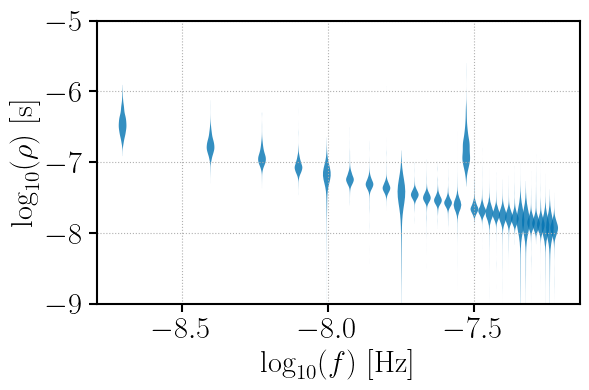

In [73]:
plt.figure(figsize=(6, 4))
parts = plt.violinplot(samples['log10_rho'].squeeze(), showextrema=False, positions=np.log10(freqs), widths=np.diff(np.log10(freqs))[15])
for b in parts['bodies']:
    b.set_alpha(0.8)
# plt.plot(np.log10(freqs),  , '-o', lw=1)
# plt.plot(np.log10(freqs), injection, '-', lw=1, label='Injected', zorder=100)
# plt.scatter(np.log10(freqs), injection, s=8, zorder=100, c='C1')
# plt.fill_between([], [], [], color='C0', alpha=0.8, label='Posterior')
plt.xlabel("$\log_{10}(f)$ [Hz]")
plt.ylabel("$\log_{10}(\\rho)$ [s]")
ax = plt.gca()
ax.tick_params(labelsize=22)
plt.ylim(-9, -5)
# plt.legend()
plt.tight_layout()
plt.savefig("../plots/dm_single_pulsar_broken_powerlaw_injection_recovery.pdf")
plt.show()

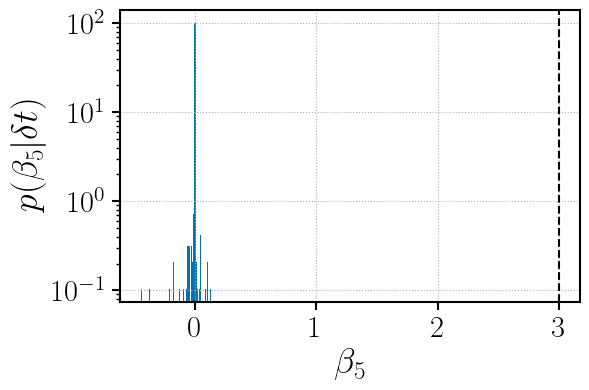

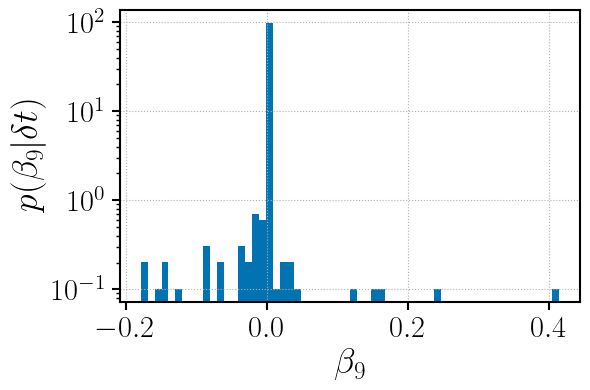

0.035196687370600416


In [58]:
plt.figure(figsize=(6, 4))
plt.hist(samples['beta_dm'][:, 4], bins=60, density=True)
plt.xlabel("$\\beta_5$", fontsize=26)
plt.ylabel('$p(\\beta_5 | \\delta t)$', fontsize=26)
ax = plt.gca()
ax.axvline(3, c='k', linestyle='--', lw=1.5)
ax.tick_params(labelsize=22)
plt.yscale("log")
plt.tight_layout()
plt.savefig("../plots/dm_single_pulsar_broken_powerlaw_beta_5_example.pdf")

plt.figure(figsize=(6, 4))
plt.hist(samples['beta_dm'][:, 8], bins=60, density=True)
plt.xlabel("$\\beta_9$", fontsize=26)
plt.ylabel('$p(\\beta_9 | \\delta t)$', fontsize=26)
ax = plt.gca()
# ax.axvline(3, c='k', linestyle='--', lw=1.5)
ax.tick_params(labelsize=22)
plt.yscale("log")
plt.tight_layout()
plt.savefig("../plots/dm_single_pulsar_broken_powerlaw_beta_9_example.pdf")

plt.show()
print(np.sum(samples['lambdas_dm'][:, 4] > 0.25) / np.sum(samples['lambdas_dm'][:, 4] < 0.25))


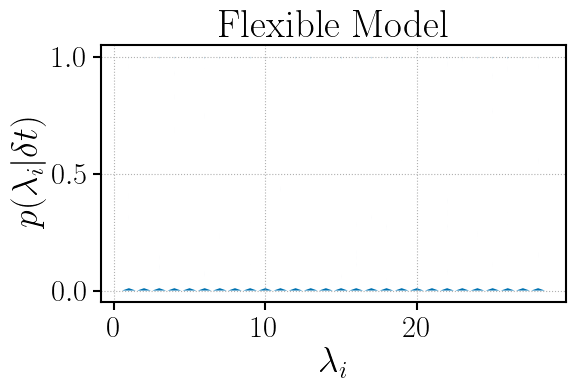

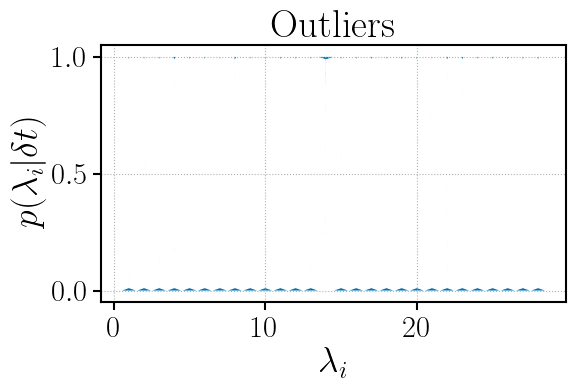

In [72]:
plt.figure(figsize=(6, 4))
plt.title("Flexible Model")
parts = plt.violinplot(samples['lambdas_dm'], showextrema=False, bw_method=0.001, widths=0.9)
for b in parts['bodies']:
    b.set_alpha(1)
plt.xlabel("$\lambda_i$", fontsize=26)
plt.ylabel("$p(\lambda_i | \delta t)$", fontsize=26)
ax = plt.gca()
ax.tick_params(labelsize=22)
plt.tight_layout()
plt.savefig("../plots/single_pulsar_dm_lambda_posteriors.pdf")
plt.show()

plt.figure(figsize=(6, 4))
plt.title("Outliers")
parts = plt.violinplot(samples['lambdas_o'], showextrema=False, bw_method=0.001, widths=0.9)
for b in parts['bodies']:
    b.set_alpha(1)
plt.xlabel("$\lambda_i$", fontsize=26)
plt.ylabel("$p(\lambda_i | \delta t)$", fontsize=26)
ax = plt.gca()
ax.tick_params(labelsize=22)
plt.tight_layout()
plt.savefig("../plots/single_pulsar_dm_lambda_outliers_posteriors.pdf")
plt.show()

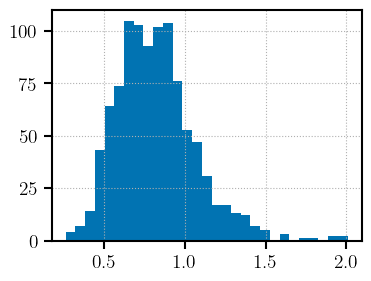

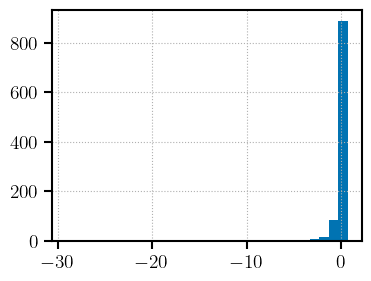

In [71]:
plt.hist(samples['beta_o'][:, 13], bins='auto')
plt.show()
plt.hist(samples['beta_o'][:, 21], bins=30)
plt.show()

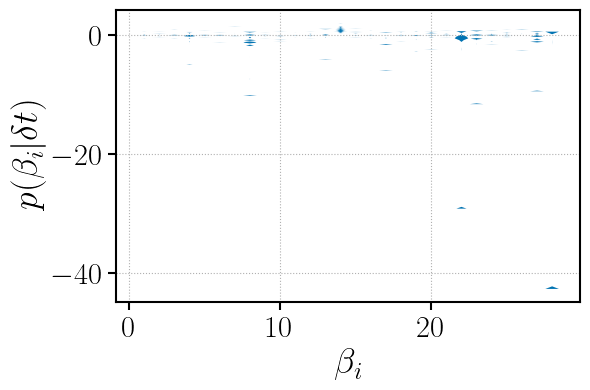

In [61]:
plt.figure(figsize=(6, 4))
parts = plt.violinplot(samples['beta_o'], showextrema=False, bw_method=0.001, widths=0.9)
for b in parts['bodies']:
    b.set_alpha(1)
plt.xlabel("$\\beta_i$", fontsize=26)
plt.ylabel("$p(\\beta_i | \delta t)$", fontsize=26)
ax = plt.gca()
ax.tick_params(labelsize=22)
plt.tight_layout()
plt.savefig("../plots/single_pulsar_dm_beta_posteriors.pdf")
plt.show()

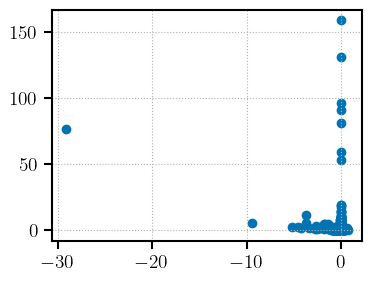

In [81]:
plt.scatter(samples['beta_o'][:, 21], samples['tau_o'])

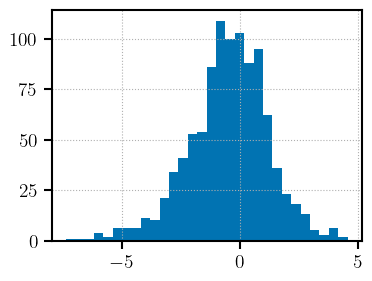

In [85]:
plt.hist(np.log(samples['tau_dm']), bins=30)
plt.show()

In [ ]:
plt.hist(samples['lambdas_rn'][:, 4], bins=30, histtype='step', density=True, label='Posterior')

lam_prior_vals = []
b_prior_vals = []
for ii in range(1000):
    idx = np.random.randint(0, samples[f'tau_rn'].shape[0])
    lam_prior = expit(np.random.randn(100, 28) * samples[f'sigma_lambda_rn'][idx] + samples[f'mu_lambda_rn'][idx])
    lam_prior_vals.extend(lam_prior.tolist())
    bvals = np.random.randn(100, 28) * lam_prior * samples[f'tau_rn'][idx]
    b_prior_vals.extend(bvals)
lam_prior_vals = np.array(lam_prior_vals)

b_prior_vals = np.array(b_prior_vals)
plt.hist(lam_prior_vals[:, 4], density=True, bins=30, histtype='step', label='Prior')
# plt.xlim(0, 0.2)
plt.yscale("log")
plt.xlabel("$\lambda_5$", fontsize=26)
plt.ylabel("$p(\lambda_5)$", fontsize=26)
plt.legend()
plt.tight_layout()
plt.savefig("../plots/single_pulsar_broken_powerlaw_lambda_5_posterior_and_prior.pdf")
plt.show()


plt.hist(samples['lambdas_rn'][:, 5], bins=30, histtype='step', density=True)

lam_prior_vals = []
b_prior_vals = []
for ii in range(1000):
    idx = np.random.randint(0, samples[f'tau_rn'].shape[0])
    lam_prior = expit(np.random.randn(100, 28) * samples[f'sigma_lambda_rn'][idx] + samples[f'mu_lambda_rn'][idx])
    lam_prior_vals.extend(lam_prior.tolist())
    bvals = np.random.randn(100, 28) * lam_prior * samples[f'tau_rn'][idx]
    b_prior_vals.extend(bvals)
lam_prior_vals = np.array(lam_prior_vals)

b_prior_vals = np.array(b_prior_vals)
plt.hist(lam_prior_vals[:, 5], density=True, bins=30, histtype='step')
# plt.xlim(0, 0.2)
plt.yscale("log")
plt.show()

plt.hist(samples['lambdas_rn'][:, 10], bins=30, histtype='step', density=True)

lam_prior_vals = []
b_prior_vals = []
for ii in range(1000):
    idx = np.random.randint(0, samples[f'tau_rn'].shape[0])
    lam_prior = expit(np.random.randn(100, 28) * samples[f'sigma_lambda_rn'][idx] + samples[f'mu_lambda_rn'][idx])
    lam_prior_vals.extend(lam_prior.tolist())
    bvals = np.random.randn(100, 28) * lam_prior * samples[f'tau_rn'][idx]
    b_prior_vals.extend(bvals)
lam_prior_vals = np.array(lam_prior_vals)

b_prior_vals = np.array(b_prior_vals)
n, bins, patches = plt.hist(lam_prior_vals[:, 10], density=True, bins=30, histtype='step')
print(np.sum(n > 0.5) / np.sum(n < 0.5))
# plt.xlim(0, 0.2)
plt.yscale("log")
plt.show()

In [ ]:
plt.scatter(samples['lambdas_rn'][:, 4], samples['tau_rn'], alpha=0.1, s=4)
plt.xlabel("$\lambda_5$", fontsize=26)
plt.ylabel("$\\tau$", fontsize=26)
plt.show()

plt.hist(samples['lambdas_rn'][:, 4] * samples['tau_rn'], bins=200, density=True)
plt.xlabel("$\lambda_5 \\tau$", fontsize=26)
plt.ylabel("$p(\lambda_5 \\tau | \delta t)$", fontsize=26)
plt.yscale("log")
# plt.xlim(0, 0.5)
plt.show()

In [ ]:
plt.violinplot(samples['beta_rn'], showextrema=False)
plt.show()
plt.violinplot(samples['lambdas_rn'], showextrema=False)
plt.show()
plt.figure(figsize=(7, 5))
bins='auto' # np.linspace(-3, 3, num=100)
plt.hist(samples['beta_rn'][:, 4], bins=bins, histtype='step', density=True)
plt.show()
# plt.hist(samples['beta_rn'][:, 5], bins=bins, histtype='step', density=True)
# plt.hist(samples['beta_rn'][:, 20], bins=bins, histtype='step', density=True)
# plt.yscale("log")
plt.show()
# plt.hist(samples['lambdas_rn'][:, 4], bins=np.linspace(0, 1, num=20), histtype='step', density=True)
# plt.hist(samples['lambdas_rn'][:, 5], bins=np.linspace(0, 1, num=20), histtype='step', density=True)
# n, bins, patches = plt.hist(samples['lambdas_rn'][:, 20], bins=np.linspace(0, 1, num=20), histtype='step', density=True)
# print(n[0] / n[-1])

In [ ]:
pinc = np.clip((samples['lambdas_rn'][:, 4] > 0.1).astype(int) + (samples['lambdas_rn'][:, 3] > 0.5).astype(int) + (samples['lambdas_rn'][:, 5] > 0.5).astype(int), 0, 1).mean()
print(pinc / (1 - pinc))

In [ ]:
n, bins, patches = plt.hist(np.sum(samples['lambdas_rn'] > 0.1, axis=1), bins=np.arange(0, 31)-0.5, histtype='step', density=True)
plt.xlabel("Number of $\\lambda_i > 0.5$")
ax = plt.gca()
ax.axvline(1, c='k', ls='--', lw=1.5)
ax.tick_params(labelsize=22)
plt.xticks(np.arange(0, 30, 5))
plt.tight_layout()
# plt.yscale("log")
plt.savefig("../plots/single_pulsar_broken_powerlaw_number_of_nodes.pdf")
plt.show()


In [ ]:
plt.plot(np.sum(samples['lambdas_rn'] > 0.2, axis=1))
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(samples['mu_lambda_rn'], c='C1', lw=1)
plt.show()

In [ ]:
plt.hist(samples['mu_lambda_rn'], bins=20, density=True, edgecolor='w')
plt.xlabel("$\mu_\lambda$", fontsize=26)
ax = plt.gca()
ax.tick_params(labelsize=18)
plt.tight_layout()
plt.savefig("../plots/single_pulsar_broken_powerlaw_mu_lambda.pdf")
plt.show()

In [ ]:
from scipy.special import expit
def plot_lncass_priors(samples, tag='rn'):
    fig, axes = plt.subplots(2, 2, figsize=(10, 7))
    axes = axes.ravel()
    # histogram sigma_lambda_rn
    axes[0].hist(samples[f'sigma_lambda_{tag}'], bins='auto', density=True, histtype='stepfilled', color='b', alpha=0.5)
    axes[0].set_title(f'$\\sigma_{{\\lambda_{{ {tag} }}}}$')
    # histogram mu_lambda_rn
    axes[1].hist(samples[f'mu_lambda_{tag}'], bins='auto', density=True, histtype='stepfilled', color='b', alpha=0.5)
    axes[1].set_title(f'$\\mu_{{\\lambda_{{ {tag} }}}}$')
    # get prior on b's
    lam_prior_vals = []
    b_prior_vals = []
    for ii in range(1000):
        idx = np.random.randint(0, samples[f'tau_{tag}'].shape[0])
        lam_prior = expit(np.random.randn(100, 28) * samples[f'sigma_lambda_{tag}'][idx] + samples[f'mu_lambda_{tag}'][idx])
        lam_prior_vals.extend(lam_prior.tolist())
        bvals = np.random.randn(100, 28) * lam_prior * samples[f'tau_{tag}'][idx]
        b_prior_vals.extend(bvals)
    lam_prior_vals = np.array(lam_prior_vals)

    b_prior_vals = np.array(b_prior_vals)
    axes[2].hist(lam_prior_vals.flatten(), bins=50, density=True, histtype='step', color='b', alpha=0.5)
    axes[2].set_title(f'$\\lambda_{{ {tag} }}$ Prior')
    axes[2].set_yscale("log")
    # axes[2].set_xscale("log")
    axes[3].hist(b_prior_vals.flatten(), bins=200, density=True, histtype='step', color='b', alpha=0.5)
    axes[3].set_yscale("log")
    # axes[3].set_ylim(0, )
    axes[3].set_title(f'$b_{{ {tag} }}$ Prior')
    plt.tight_layout()
    plt.show()

In [ ]:
plot_lncass_priors(samples)
# plot_lncass_priors(samples, tag='o')


In [ ]:

import matplotlib.gridspec as gridspec

def plot_lncass_posteriors(samples, tag='rn'):
    fig, axes = plt.subplots(2, 1, figsize=(10, 7))
    axes = axes.ravel()
    axes[0].violinplot(samples[f'beta_{tag}'], showextrema=False)
    axes[0].set_title(f'$\\beta_{{ {tag} }}$')
    
    axes[1].violinplot(samples[f'lambdas_{tag}'], showextrema=False)
    axes[1].set_title(f'$\\lambda_{{ {tag} }}$')
    
    plt.tight_layout()
    plt.show()

plot_lncass_posteriors(samples)
# plot_lncass_posteriors(samples, tag='o')

# Other Samplers


In [ ]:
from numpyro_ext import optim as optimx
# pat = optimx.JAXOptMinimize(maxiter=1000)

In [ ]:
soln = optimx.optimize(model, return_info=True, num_steps=1)(jax.random.PRNGKey(101), prior_dict=prior_dict)

In [ ]:
plt.plot(soln[0]['log10_rho'])
plt.plot(injection)

In [ ]:

# barker_sampler = infer.MCMC(
#     infer.BarkerMH(model,dense_mass=True, target_accept_prob=0.95),
#     num_warmup=20_000,
#     num_samples=10_000,
#     num_chains=1,
#     progress_bar=True,chain_method='vectorized'
# )

kernel = infer.SA(model)

aies_sampler = infer.MCMC(
    kernel,
    num_warmup=100000,
    num_samples=5000,
    num_chains=1,
    progress_bar=True,chain_method='vectorized'
)

In [ ]:
print(jnp.repeat(soln[0]['log10_rho'], 100).reshape(30, 100)[:, 0])


In [ ]:
prior_dict = {**PRIOR_DICT, 'tau': dist.Uniform(4.999, 5.),
              'sigma_lambda':dist.Uniform(4.999, 5.001),
              'mu_lambda': dist.Uniform(-50, 50)}
# lncass_outliers_sampler = infer.MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=200, chain_method='vectorized')
aies_sampler.run(jax.random.PRNGKey(0), prior_dict=prior_dict, init_params={f'{psrname}_red_noise_log10_rho(30)': soln[0]['log10_rho']})

In [ ]:
samples_barker = aies_sampler.get_samples()
plt.violinplot(samples_barker['log10_rho'].squeeze(), showextrema=False)
plt.plot(injection)
plt.plot(soln[0]['log10_rho'])
plt.show()

In [ ]:
plt.violinplot(samples_barker['lambdas_rn'].squeeze())
plt.show()

In [ ]:
# from numpyro.contrib.tfp.mcmc import TFPKernel
import tensorflow_probability as tfp

kernel_test = TFPKernel[tfp.mcmc.NoUTurnSampler](model, step_size=1.)



# Power law

In [ ]:
pl_model = lncass_models.create_single_psr_powerlaw_model(psr, n_rn_freqs)
pl_sampler = infer.MCMC(
    infer.NUTS(pl_model, max_tree_depth=10),
    num_warmup=20000,
    num_samples=2000,
    num_chains=1,
    progress_bar=True,chain_method='vectorized'
)

In [ ]:
with numpyro.validation_enabled():
    pl_sampler.run(jax.random.PRNGKey(13))

In [ ]:
pl_sampler.print_summary()

In [ ]:
fspec_model = lncass_models.create_single_psr_freespec_model(psr, n_rn_freqs)
fspec_sampler = infer.MCMC(
    infer.NUTS(fspec_model, max_tree_depth=10),
    num_warmup=20000,
    num_samples=2000,
    num_chains=1,
    progress_bar=True,chain_method='vectorized'
)

In [ ]:
with numpyro.validation_enabled():
    fspec_sampler.run(jax.random.PRNGKey(13))

In [ ]:
fspec_sampler.print_summary()

In [ ]:
fspec_samples = fspec_sampler.get_samples()
pl_samples = pl_sampler.get_samples()

In [ ]:
pl_samples.keys()

In [ ]:
freqs = np.arange(1, 31) / ds.getspan([psr])
fyr = 1 / 365.25 / 86400
pl_rhos = np.array([np.log10(10**(2*pl_samples['log10_A'][idx]) / (12 * np.pi**2) * (freqs / fyr)**(-pl_samples['log10_gamma'][idx]) * fyr**-3 / ds.getspan([psr])) / 2  for idx in range(1000)])

In [ ]:
pl_rhos.shape

In [ ]:
plt.figure(figsize=(10, 4))
plt.violinplot(fspec_samples['log10_rho'].squeeze(), showextrema=False, side="low", widths=0.9)
plt.violinplot(samples['log10_rho'].squeeze(), showextrema=False, side="high", widths=0.9)
freqs = np.arange(1, 31) / ds.getspan([psr])
plt.plot(np.arange(1, n_rn_freqs+1), injection, '-o', lw=1)

plt.ylim(-8, -4)

for ii in range(500):
    idx = np.random.randint(0, pl_samples['log10_A'].shape[0])
    tr = np.log10(10**(2*pl_samples['log10_A'][idx]) / (12 * np.pi**2) * (freqs / fyr)**(-pl_samples['log10_gamma'][idx]) * fyr**-3 / ds.getspan([psr])) / 2
    plt.plot(np.arange(1, 31), tr, c='k', alpha=0.002, zorder=-1000)

# Direct deviation from power law

In [ ]:
spline_model = lncass_models.create_rn_single_psr_spline_model(psr, n_rn_freqs, 20)
spline_sampler = infer.MCMC(
    infer.NUTS(spline_model, max_tree_depth=10),
    num_warmup=20000,
    num_samples=2000,
    num_chains=1,
    progress_bar=True,chain_method='vectorized'
)

In [ ]:
with numpyro.validation_enabled():
    spline_sampler.run(jax.random.PRNGKey(23), prior_dict={**PRIOR_DICT})

In [ ]:
spline_sampler.print_summary()

In [ ]:
spline_samples = spline_sampler.get_samples()

In [ ]:
plt.figure(figsize=(10, 8))
plt.violinplot(spline_samples['log10_rho'].squeeze(), showextrema=False, side="low", widths=0.9)
plt.violinplot(samples['log10_rho'].squeeze(), showextrema=False, side="high", widths=0.9)
# plt.violinplot(pl_rhos, showextrema=False, side="high", widths=0.9)
plt.ylim(-8, -2)
plt.plot(np.arange(1, n_rn_freqs+1),  injection, '-o')
# for ii in range(1000):
#     idx = np.random.randint(0, pl_samples['log10_A'].shape[0])
#     tr = np.log10(10**(2*pl_samples['log10_A'][idx]) / (12 * np.pi**2) * (freqs / fyr)**(-pl_samples['log10_gamma'][idx]) * fyr**-3 / ds.getspan([psr])) / 2
#     plt.plot(np.arange(1, 31), tr, c='k', alpha=0.002, zorder=-1000)
plt.show()

In [ ]:
plt.violinplot(spline_samples['beta_rn'].squeeze(), showextrema=False, widths=0.9)
plt.ylim(-2, 2)
plt.show()